In [ ]:
import torch

try:
    import google.colab
    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False

# Make use of a GPU or MPS (Apple) if one is available.  (see module 3.2)
import torch
has_mps = torch.backends.mps.is_built()
device = "mps" if has_mps else "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

In [ ]:
import pandas as pd
import urllib.request
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
dirmodelo = 'modelo/' # directorio donde estan los modelos


# Set Pandas display options
pd.set_option('display.max_columns', 6)
pd.set_option('display.max_rows', 5)

# Download the file using urllib
# Download the file using urllib
# url = 'https://github.com/jeffheaton/jheaton-ds2/rawmain/kdd-with-columns.csv'
filename =  'data/DMZServiciosN4_Web_U_EX240226.log'



if not os.path.isfile(filename):
        print('documento no encontrado :' + filename)
    
print(filename)
columnanombre = 'No cargo aun el archivo'
# Cargo titulos de columnas
with open(filename, 'r') as file:
    for line in file:
        if line.startswith('#Fields:'):
            # Eliminar el prefijo y el salto de línea, luego dividir por espacio
            columnanombre = line.replace('#Fields:', '').strip().split()
            break

print(columnanombre)


# Se cargan los datos con las columnas a utilizar
cols_to_use = ['time', 'cs-method', 'cs-uri-stem', 'cs-username','c-ip','sc-status'
                                                         ,'sc-bytes','cs-bytes','time-taken']
df = pd.read_csv(filename, sep=' ', names=columnanombre, comment='#',usecols=cols_to_use)

#df = pd.read_csv(filename, sep=' ')
print (df)
print("Read {} rows.".format(len(df)))

# Display 5 rows
pd.set_option('display.max_columns', 15)
pd.set_option('display.max_rows', 15)
              
print(df)

In [ ]:
### Comienza el trabajo con los datos para CATEGORIZAR LOS CAMPOS

In [ ]:
### Campo time
def categorizar_por_hora(time):
    hora = int(time.split(':')[0])  # Convertimos a entero el primer elemento luego de hacer split por ':'
    H = np.zeros(4, dtype=bool)
    
    # Ahora, categorizamos según los rangos definidos
    if (6 <= hora < 9) :
        H[0] = True
    elif 9 <= hora < 19:
        H[1] = True
    elif hora >= 23 or hora < 6:
        H[2] = True
    else: # (19 <= hora < 23)
        H[3] = True
    return (H) 

### Campo sc-status 
# Crear la nueva columna 'status-cat' basada en la condición
def buscoE(statuscat):
   E = np.zeros(3, dtype=bool)
   if (statuscat == '200') :
       E[0] = True
   else :
       E[1] = True
   return (E) 
    
def buscolista (elemento,lista):
    try:
        indice = lista.index(elemento)
        return indice
    except ValueError:
        return -1

def generoValor(elemento, lista, cantelementos ):
   P = np.zeros(cantelementos, dtype=bool)
   indice = buscolista(elemento, lista) 
   if (indice == -1) :
       P[cantelementos-1] = True
   else :
       P[indice] = True
   return (P) 

def procesar_ip(ip):
    octetos = ip.split('.')
    # lo pasamos a 3 digitos llenando de 0
    octetos = [octeto.zfill(3) for octeto in octetos]
    primer_octeto = int(octetos[0])
    segundo_octeto = int(octetos[1])
    
    # Comprueba los dos primeros octetos
    if primer_octeto == 172 and segundo_octeto == 20:
        # Si los dos primeros octetos son 172 y 20, respectivamente, toma solo los dos primeros
        return ''.join(octetos[:2])
    else:
        # De lo contrario, tom los tres primeros octetos
        return ''.join(octetos[:2]) # 
        # return ''.join(octetos[:3])

with open(dirmodelo + 'lista_categorias_csuristem.csv', 'r') as archivo:
    top_20_csuristem = [linea.strip() for linea in archivo.readlines() if linea.strip()]

with open(dirmodelo + 'lista_categorias_csusername.csv', 'r') as archivo:
    top_20_usernames = [linea.strip() for linea in archivo.readlines() if linea.strip()]

with open(dirmodelo + 'lista_categorias_IPClientes.csv', 'r') as archivo:
    top_20_IP = [linea.strip() for linea in archivo.readlines() if linea.strip()]
    
categoria_csmethod = ['GET','POST']

df['cs-uri-stem'] = df['cs-uri-stem'].str.split('/').str[-1]
df['cs-username'] = df['cs-username'].str.replace('^(?i)dna\\\\', '', regex=True)

### Campo cs-bytes categorizacion
import joblib
#Cargo modelo guardado
gmm = joblib.load(dirmodelo + 'gmm_csbyte.pkl')
scaler = joblib.load(dirmodelo + 'gmmscaler_csbyte.pkl')

df['cs-bytes'] = pd.to_numeric(df['cs-bytes'], errors='coerce').fillna(0)

cs_bytes_scaled = scaler.transform(df[['cs-bytes']])
df['cs-bytes-category'] = gmm.predict(cs_bytes_scaled)

### Campo sc-bytes categorizacion
import joblib
#Cargo modelo guardado
gmm = joblib.load(dirmodelo + 'gmm_scbyte.pkl')
scaler= joblib.load(dirmodelo + 'gmmscaler_scbyte.pkl')

df['sc-bytes'] = pd.to_numeric(df['sc-bytes'], errors='coerce').fillna(0)

sc_bytes_scaled = scaler.transform(df[['sc-bytes']])
df['sc-bytes-category'] = gmm.predict(sc_bytes_scaled)

### Campo time-taken 
import joblib
#Cargo modelo guardado

gmm = joblib.load(dirmodelo + 'gmm_timetaken.pkl')
scaler= joblib.load(dirmodelo + 'gmmscaler_timetaken.pkl')

df['time-taken'] = pd.to_numeric(df['time-taken'], errors='coerce').fillna(0)
time_taken_scaled = scaler.transform(df[['time-taken']])

df['time-taken-cat'] = gmm.predict(time_taken_scaled)

def buscoV (logp):
   p  = np.zeros(3, dtype=bool)
   if logp.upper() == 'GET':
        p[0] = True
   elif logp.upper() == 'POST':
        p[1] = True
   else:
        p[2] = True
    
   return p

In [ ]:
# Genero nuevo dataframe convirtiendo cada fila incial categorizada en la nueva estructura

In [ ]:
# Lista de nuevas filas
new_vector = []

# Iterar sobre cada fila del DataFrame original
for index, row in df.iterrows():
    V_Vacio = np.zeros(3, dtype=bool)
    P_Vacio = np.zeros(20, dtype=bool)
    U_Vacio = np.zeros(20, dtype=bool)
    I_Vacio = np.zeros(20, dtype=bool)
    C_Vacio = np.zeros(16, dtype=bool)
    S_Vacio = np.zeros(18, dtype=bool)
    H_Vacio = np.zeros(4, dtype=bool)
    T_Vacio = np.zeros(19, dtype=bool)
    E_Vacio = np.zeros(3, dtype=bool)
    # Convertir las matrices booleanas a cadenas
    P = generoValor(row['cs-uri-stem'], top_20_csuristem, 20)
    I = generoValor(procesar_ip(row['c-ip']), top_20_IP, 20)
    U = generoValor(row['cs-username'], top_20_usernames, 20)
    V = buscoV (row['cs-method'])
    E = buscoE(row['sc-status'])
    H = categorizar_por_hora(row['time'])
    S = np.zeros(18, dtype=bool)
    S[row['sc-bytes-category']] = True
    C = np.zeros(16, dtype=bool)
    C[row['cs-bytes-category']] = True
    T = np.zeros(19, dtype=bool)
    T[row['time-taken-cat']-1] = True
    
    
    NodoAplicacion = np.concatenate((P, V_Vacio,  U_Vacio, I_Vacio , C_Vacio,S_Vacio,H_Vacio, T_Vacio, E_Vacio))
    
    NodoIpCliente =  np.concatenate((P_Vacio, V_Vacio,  U_Vacio, I , C_Vacio,S_Vacio,H_Vacio, T_Vacio, E_Vacio)) 
    #print (len(E))
    NodoUsuario   = np.concatenate((P_Vacio, V_Vacio,  U, I_Vacio , C_Vacio,S_Vacio,H_Vacio, T_Vacio, E_Vacio)) 
    NodoConexion  =  np.concatenate((P_Vacio, V,  U_Vacio, I_Vacio , C , S , H , T , E)) 
    #print (len(T))
    
    
    A1 = np.zeros(3, dtype=bool)
    A1[2] = True
    #A1 = ''.join(A1.astype(int).astype(str))
    Arista1  = np.concatenate((A1 , NodoConexion , NodoUsuario))
    A2 = np.zeros(3, dtype=bool)
    A2[1] = True
    #A2 = ''.join(A2.astype(int).astype(str))
    Arista2  = np.concatenate((A2 , NodoConexion , NodoAplicacion))
    #AristaTipo3  = '100'
    A3 = np.zeros(3, dtype=bool)
    A3 [0] = True
    #A3 = ''.join(A3.astype(int).astype(str))
    Arista3  = np.concatenate((A3, NodoConexion , NodoIpCliente))
    
    new_vector.append(Arista1)
    new_vector.append(Arista2)
    new_vector.append(Arista3)

print (len(Arista1), len(Arista2), len(Arista3), len(new_vector))

In [ ]:
# convierte  a una estructura de bits
def string_a_lista(cadena):
    return [int(char) for char in cadena]

# Convertir cada cadena en una lista de enteros y luego en un tensor
tensores = [torch.tensor(string_a_lista(cadena)) for cadena in new_vector]
# 
# Concatenar los tensores en una sola dimensión
tensor_concatenado = torch.stack(tensores)

print(tensor_concatenado)

In [ ]:
# Evaluacion de los datos

In [ ]:
from torch.utils.data import DataLoader, TensorDataset
x_normal_train = np.array(tensor_concatenado)
# Convert numpy arrays to PyTorch tensors and move them to the appropriate device
x_normal_tensor = torch.tensor(x_normal_train).float().to(device)
datos = TensorDataset(x_normal_tensor, x_normal_tensor)
datos_loader = DataLoader(datos, batch_size=32, shuffle=True)
print (len(datos_loader), len(datos))


In [ ]:
#Evaluacion nuevo trafico

In [ ]:
 import torch
import torch.nn as nn
import torch.optim as optim

class BifurcatedAutoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim, encoding_dim2, decoder_dim2 ,decoder_dim3, output_dim1, output_dim2, output_dim3):
        super(BifurcatedAutoencoder, self).__init__()
        
        # Encoder inicial
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim),
            nn.Sigmoid()
        )

        #  Encoder nivel 2
        self.encoder2 = nn.Sequential(
            nn.Linear(encoding_dim, encoding_dim2),
            nn.Sigmoid()
        )

        # Decoder Salida 1
        self.decoder1 = nn.Sequential(
            nn.Linear(encoding_dim2, output_dim1),
            nn.Softmax(dim=1)
        )
        
        # Decoder a siguiente paralelo 2
        self.decoder2 = nn.Sequential(
            nn.Linear(encoding_dim2, decoder_dim2),
            nn.Sigmoid()
        )
                
        # Decoder 2 hacia salida paralelo 2
        self.decoder2a = nn.Sequential(
            nn.Linear(decoder_dim2, output_dim2),
            nn.Sigmoid()
            #nn.ReLU(True)
        )
        # Decoder a siguiente paralelo 3
        self.decoder3 = nn.Sequential(
            nn.Linear(encoding_dim2, decoder_dim3),
            nn.Sigmoid()
        )
        # Decoder 2 hacia salida paralelo 3
        self.decoder3a = nn.Sequential(
            nn.Linear(decoder_dim3, output_dim3),
            nn.Sigmoid()
            #nn.ReLU(True)
        )

    
    def forward(self, x):
        encoded = self.encoder(x)
        encoded2 = self.encoder2(encoded)
        output_dim1 = self.decoder1(encoded2)
        decoded2 = self.decoder2(encoded2)
        output_dim2 = self.decoder2a(decoded2)
        decoded3 = self.decoder3(encoded2)
        output_dim3 = self.decoder3a(decoded3)
        return output_dim1, output_dim2,output_dim3 ,torch.cat((output_dim1, output_dim2,output_dim3), dim=1)




# Dimensiones ejemplo
input_dim = 249  # Dimensión del vector de entrada
encoding_dim = 180 # Dimensión del espacio latente (codificado)
encoding_dim2 = 70 
decoder_dim2 = 100
decoder_dim3 = 100
output_dim1 = 3  # Dimensiones de las partes de salida
output_dim2 = 123
output_dim3 = 123
# Crear el modelo
model = BifurcatedAutoencoder(input_dim, encoding_dim, encoding_dim2 ,decoder_dim2, decoder_dim3, output_dim1, output_dim2, output_dim3)
  
        

In [57]:

#model.load_state_dict(torch.load(dirmodelo+'modelo_entrenado_solo_un_error.pth'))
model.load_state_dict(torch.load(dirmodelo+'modelo_entrenado_errorsimple_minV66_Adamw.pth'))
# Colocar el modelo en modo de evaluación
model.eval()
all_outputs = []
all_losses1 = []
criterion = nn.MSELoss()
indice = 0
df1 = df
df1['ErrorArista1'] = None
df1['ErrorArista2'] = None
df1['ErrorArista3'] = None
indiceDf = 0
step = 3

with torch.no_grad():
       
    for inputs, _ in datos_loader:
        input_batches = torch.split(inputs, 1)

        # Iterar sobre cada bloque de tres filas de entrada
        for indice2, input_batch in enumerate(input_batches):
    
        
            if indice % step == 0:
                 output1, output2, output3, outputs = model(input_batch)
                 loss = criterion(outputs, input_batch)
                 df1.at[indiceDf, 'ErrorArista1'] = loss.item()
                 loss_total = loss.item()
                 #print (indiceDf , indice% step , loss.item())    
                 input_batches = torch.split(inputs, 3)
            elif indice % step == 1:
                 output1, output2, output3, outputs = model(input_batch)
                 loss = criterion(outputs, input_batch)
                 df1.at[indiceDf, 'ErrorArista2'] = loss.item()
                 loss_total = loss_total + loss.item()
                 #print (indiceDf , indice% step , loss.item())
            else:
                 output1, output2, output3, outputs = model(input_batch)
                 loss = criterion(outputs, input_batch)
                 df1.at[indiceDf, 'ErrorArista3'] = loss.item()
                 # print (indiceDf , indice% step , loss.item())
                 df1.at[indiceDf, 'ErrorTotal'] = loss.item() + loss_total
                 loss_total = 0
                 #all_outputs.append(outputs)
                 all_losses1.append(df1.at[indiceDf, 'ErrorTotal'])
                 indiceDf += 1
            indice += 1
                      

# Nombre del archivo con la fecha y hora actual
nombre_archivo = 'data\Salida_TestingConerrorSimple.csv' # + f"Testing_Esimple_{timestamp}.csv"
# Guardar el DataFrame en un archivo CSV con el nombre generado
df1.to_csv(nombre_archivo, index=False)
pd.set_option('display.max_columns', None)
print (df1)

            time cs-method                     cs-uri-stem cs-username  \
0       00:00:00      POST                  aWSPrcRpt.aspx     Otr9767   
1       00:00:00      POST                aWSPrcRptV2.aspx           -   
2       00:00:00      POST                aWSPrcRptV2.aspx     OTR0662   
3       00:00:00      POST                  aWSPrcRpt.aspx     Otr9767   
4       00:00:00      POST                 awsdatcont.aspx           -   
...          ...       ...                             ...         ...   
330913  23:59:57      POST                aWSPrcRptV2.aspx     OTR0662   
330914  23:59:58      POST  aWSCntEncomiendasPostales.aspx     OTR3552   
330915  23:59:58      POST                     awsdua.aspx        0642   
330916  23:59:59      POST                  awsprcrpt.aspx        3001   
330917  23:59:59      POST                  awsprcrpt.aspx     OTR4085   

                  c-ip  sc-status  sc-bytes  cs-bytes  time-taken  \
0        179.27.96.252      200.0     741.

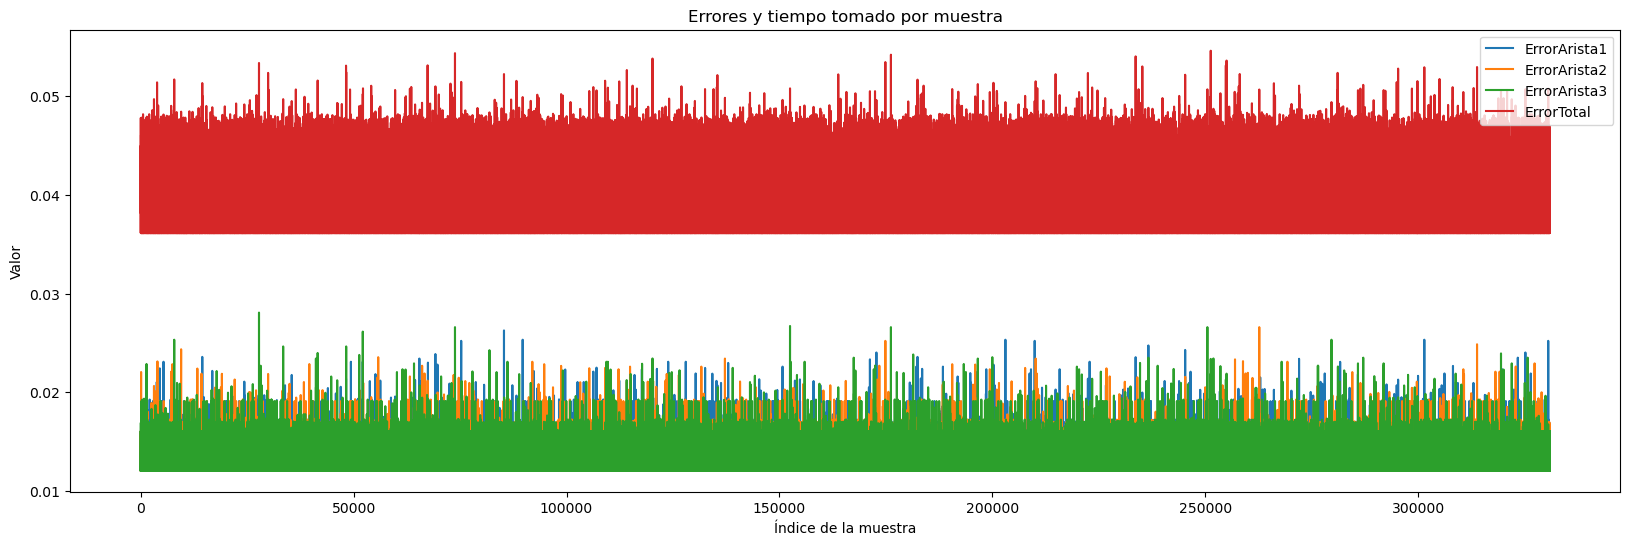

In [58]:
import matplotlib.pyplot as plt
columnas_para_graficar = ['ErrorArista1', 'ErrorArista2','ErrorArista3', 'ErrorTotal']

# Graficar las columnas seleccionadas
df1[columnas_para_graficar].plot(kind='line', figsize=(20, 6))

# Personalizar el gráfico
plt.xlabel('Índice de la muestra')
plt.ylabel('Valor')
plt.title('Errores y tiempo tomado por muestra')

# Mostrar el gráfico
plt.show()

In [62]:
valorErrorMaximo = 0.047
print( 'Testing - Error simple - AdamW')
df_Evaluado = df1[df1['ErrorTotal'] <= valorErrorMaximo].copy()
print ('Cantidad elementos considerados mormales ' , len(df_Evaluado) , 'elementos de' , len(df1))
print ("{:.3f}".format(len(df_Evaluado)/len(df1)), '% considerados anomalias con valor superiores a', valorErrorMaximo, 'de error.' )

Testing - Error simple - AdamW
Cantidad elementos considerados mormales  328516 elementos de 330918
0.993 % considerados anomalias con valor superiores a 0.047 de error.


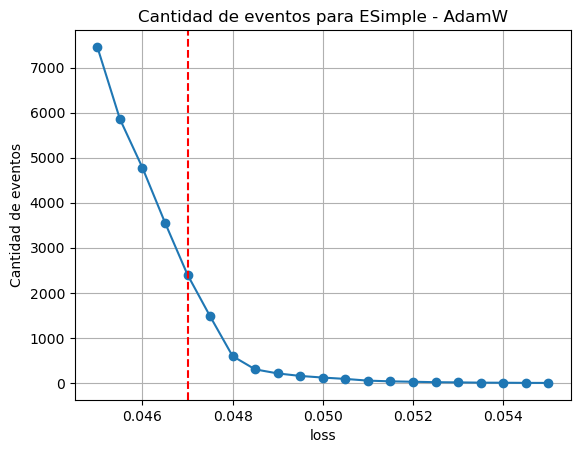

In [66]:

valores_a_contar = np.arange(0.045, 0.055, 0.0005)
cantidad_elementos = []

# Itera sobre los valores definidos
for valor in valores_a_contar:
    # Cuenta la cantidad de elementos menores que el valor en la columna 'columna' del DataFrame
    cantidad = len(df1[df1['ErrorTotal'] > valor])
    cantidad_elementos.append(cantidad)

# Grafica
plt.plot(valores_a_contar, cantidad_elementos, marker='o')
plt.xlabel('loss')
plt.grid(which='both')
plt.ylabel('Cantidad de eventos')
plt.title('Cantidad de eventos para ESimple - AdamW')
plt.axvline(x=valorErrorMaximo, color='red', linestyle='--')
plt.grid(True)
plt.show()

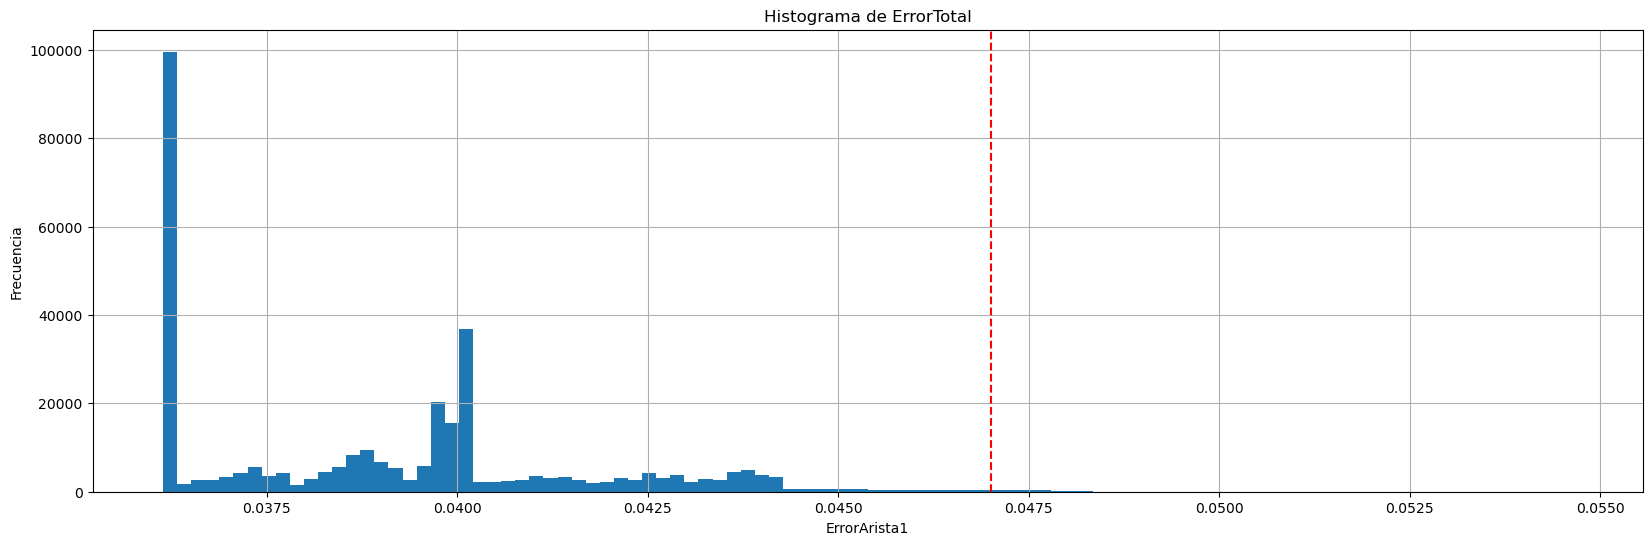

In [64]:
import matplotlib.pyplot as plt
df1['ErrorTotal'].hist(bins=100,figsize=(20, 6))

# Personalizar el gráfico
plt.xlabel('ErrorArista1')
plt.ylabel('Frecuencia')
plt.title('Histograma de ErrorTotal')
plt.axvline(x=valorErrorMaximo, color='red', linestyle='--')
# Mostrar el histograma
plt.show()

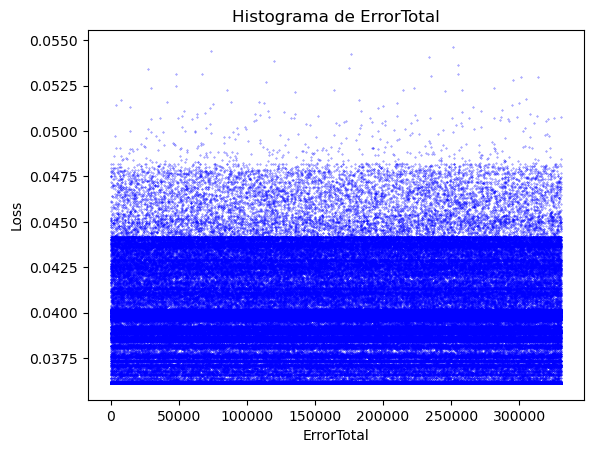

In [65]:
plt.scatter(range(len(df1['ErrorTotal'])), df1['ErrorTotal'], color='blue', alpha=0.7, s=0.1)
# Personalizar el gráfico
plt.xlabel('ErrorTotal')
plt.ylabel('Loss')
plt.title('Histograma de ErrorTotal')

# Mostrar el histograma
plt.show()

In [ ]:
# Evaluacion de testing para Error compuesto con AdamW como optimizador.

In [56]:

#model.load_state_dict(torch.load(dirmodelo+'modelo_entrenado_solo_un_error.pth'))
model.load_state_dict(torch.load(dirmodelo+'modelo_entrenado_errorcompuesto_minV66_Adamw.pth'))
# Colocar el modelo en modo de evaluación
model.eval()
all_outputs = []
all_losses = []
criterion = nn.MSELoss()
indice = 0
df2 = df
df2['ErrorArista1'] = None
df2['ErrorArista2'] = None
df2['ErrorArista3'] = None
indiceDf = 0
step = 3
with torch.no_grad():
       
    for inputs, _ in datos_loader:
        input_batches = torch.split(inputs, 1)

        # Iterar sobre cada bloque de tres filas de entrada
        for indice2, input_batch in enumerate(input_batches):
    
        
            if indice % step == 0:
                 output1, output2, output3, outputs = model(input_batch)
                 loss = criterion(outputs, input_batch)
                 df2.at[indiceDf, 'ErrorArista1'] = loss.item()
                 loss_total = loss.item()
                 #print (indiceDf , indice% step , loss.item())    
                 input_batches = torch.split(inputs, 3)
            elif indice % step == 1:
                 output1, output2, output3, outputs = model(input_batch)
                 loss = criterion(outputs, input_batch)
                 df2.at[indiceDf, 'ErrorArista2'] = loss.item()
                 loss_total = loss_total + loss.item()
                 #print (indiceDf , indice% step , loss.item())
            else:
                 output1, output2, output3, outputs = model(input_batch)
                 loss = criterion(outputs, input_batch)
                 df2.at[indiceDf, 'ErrorArista3'] = loss.item()
                 # print (indiceDf , indice% step , loss.item())
                 df2.at[indiceDf, 'ErrorTotal'] = loss.item() + loss_total
                 loss_total = 0
                 #all_outputs.append(outputs)
                 all_losses.append(df2.at[indiceDf, 'ErrorTotal'])
                 indiceDf += 1
            indice += 1
            all_outputs.append(outputs)
            all_losses.append(loss)
            #print (indice2)
from datetime import datetime
now = datetime.now()        
timestamp = now.strftime("%Y-%m-%d_%H-%M-%S")
# Nombre del archivo con la fecha y hora actual
nombre_archivo = 'data\prueba.csv' # + f"Testing_Esimple_{timestamp}.csv"
# Guardar el DataFrame en un archivo CSV con el nombre generado
df2.to_csv(nombre_archivo, index=False)
pd.set_option('display.max_columns', None)
print (df2)

            time cs-method                     cs-uri-stem cs-username  \
0       00:00:00      POST                  aWSPrcRpt.aspx     Otr9767   
1       00:00:00      POST                aWSPrcRptV2.aspx           -   
2       00:00:00      POST                aWSPrcRptV2.aspx     OTR0662   
3       00:00:00      POST                  aWSPrcRpt.aspx     Otr9767   
4       00:00:00      POST                 awsdatcont.aspx           -   
...          ...       ...                             ...         ...   
330913  23:59:57      POST                aWSPrcRptV2.aspx     OTR0662   
330914  23:59:58      POST  aWSCntEncomiendasPostales.aspx     OTR3552   
330915  23:59:58      POST                     awsdua.aspx        0642   
330916  23:59:59      POST                  awsprcrpt.aspx        3001   
330917  23:59:59      POST                  awsprcrpt.aspx     OTR4085   

                  c-ip  sc-status  sc-bytes  cs-bytes  time-taken  \
0        179.27.96.252      200.0     741.

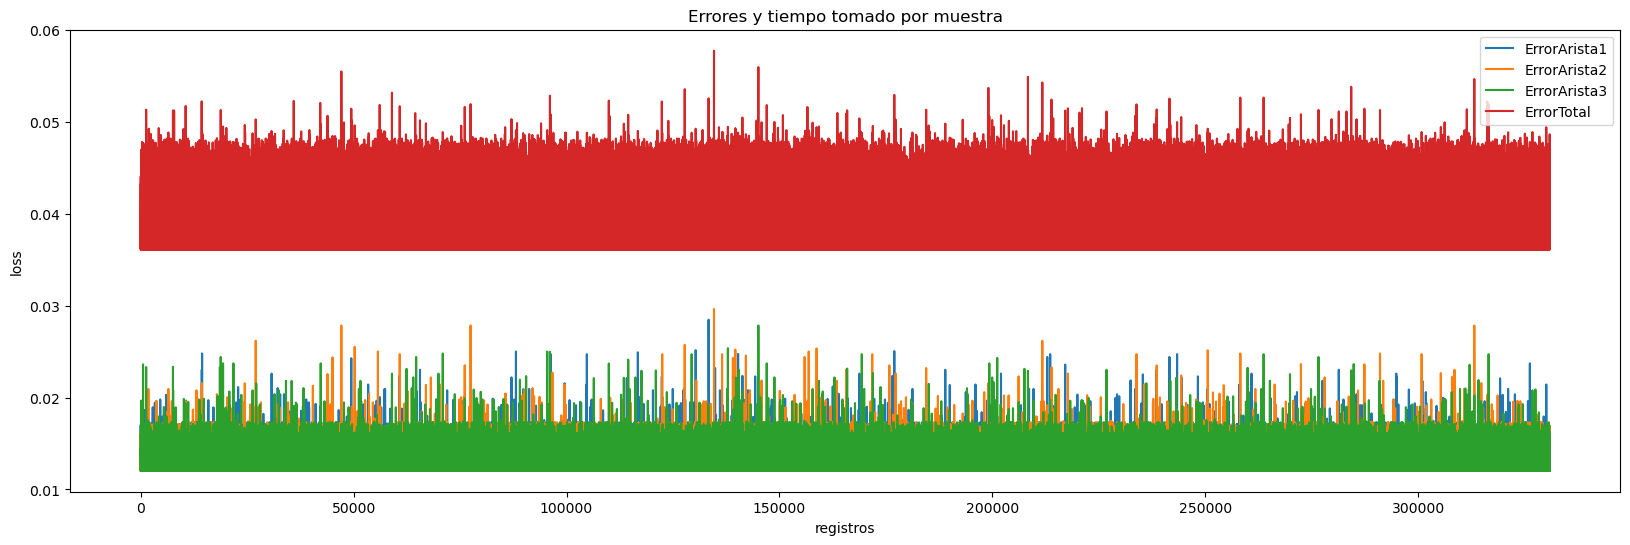

In [44]:
import matplotlib.pyplot as plt
columnas_para_graficar = ['ErrorArista1', 'ErrorArista2','ErrorArista3', 'ErrorTotal']

# Graficar las columnas seleccionadas
df2[columnas_para_graficar].plot(kind='line', figsize=(20, 6))

# Personalizar el gráfico
plt.xlabel('registros')
plt.ylabel('loss')
plt.title('Errores y tiempo tomado por muestra')

# Mostrar el gráfico
plt.show()

In [61]:
valorErrorMaximo2 = 0.047

print( 'Testing - Error compuesto - AdamW')
df_Evaluado2 = df2[df2['ErrorTotal'] <= valorErrorMaximo2].copy()
print ('Cantidad elementos considerados mormales ' , len(df_Evaluado2) , 'elementos de' , len(df2))
print ("{:.3f}".format(len(df_Evaluado)/len(df2)), '% considerados anomalias con valor superiores a', valorErrorMaximo2, 'de error.' )

Testing - Error compuesto - AdamW
Cantidad elementos considerados mormales  328516 elementos de 330918
0.993 % considerados anomalias con valor superiores a 0.047 de error.


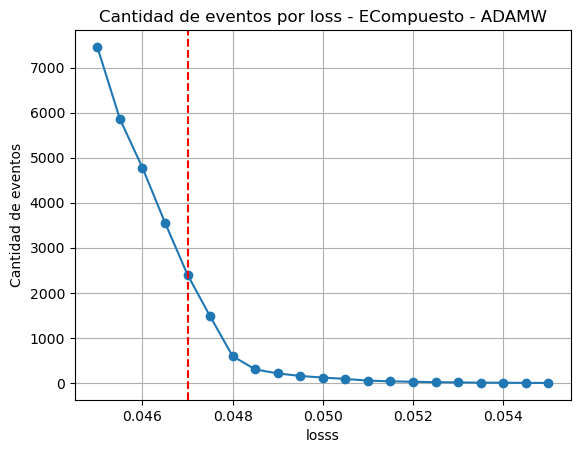

In [60]:
# grafico  sumatoria de valores
valores_a_contar = np.arange(0.045, 0.055, 0.0005)
cantidad_elementos = []
for valor in valores_a_contar:
    cantidad = len(df2[df2['ErrorTotal'] > valor])
    cantidad_elementos.append(cantidad)

# Grafica
plt.plot(valores_a_contar, cantidad_elementos, marker='o')
plt.xlabel('losss')
plt.grid(which='both')
plt.ylabel('Cantidad de eventos')
plt.title('Cantidad de eventos por loss - ECompuesto - ADAMW')
plt.axvline(x=valorErrorMaximo, color='red', linestyle='--')
plt.grid(True)
plt.show()

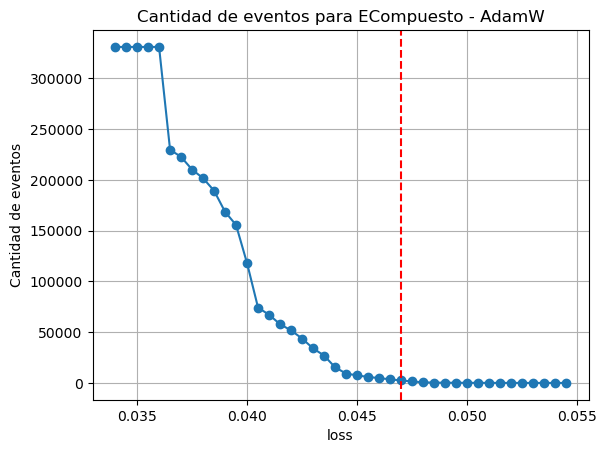

In [67]:
valores_a_contar = np.arange(0.034, 0.055, 0.0005)
cantidad_elementos = []

# Itera sobre los valores definidos
for valor in valores_a_contar:
    # Cuenta la cantidad de elementos menores que el valor en la columna 'columna' del DataFrame
    cantidad = len(df2[df2['ErrorTotal'] > valor])
    cantidad_elementos.append(cantidad)

# Grafica
plt.plot(valores_a_contar, cantidad_elementos, marker='o')
plt.xlabel('loss')
plt.grid(which='both')
plt.ylabel('Cantidad de eventos')
plt.title('Cantidad de eventos para ECompuesto - AdamW')
plt.axvline(x=valorErrorMaximo, color='red', linestyle='--')
plt.grid(True)
plt.show()

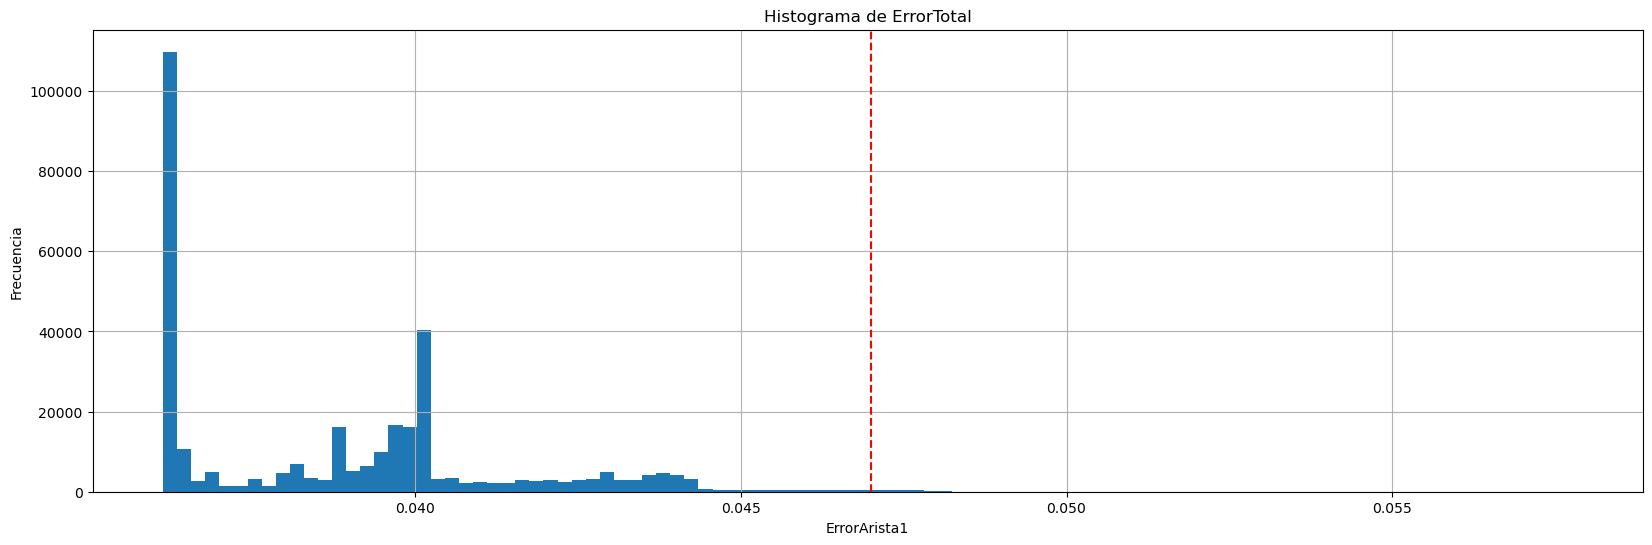

In [51]:
import matplotlib.pyplot as plt
df2['ErrorTotal'].hist(bins=100,figsize=(20, 6))

# Personalizar el gráfico
plt.xlabel('ErrorArista1')
plt.ylabel('Frecuencia')
plt.title('Histograma de ErrorTotal')
plt.axvline(x=valorErrorMaximo, color='red', linestyle='--')
# Mostrar el histograma
plt.show()

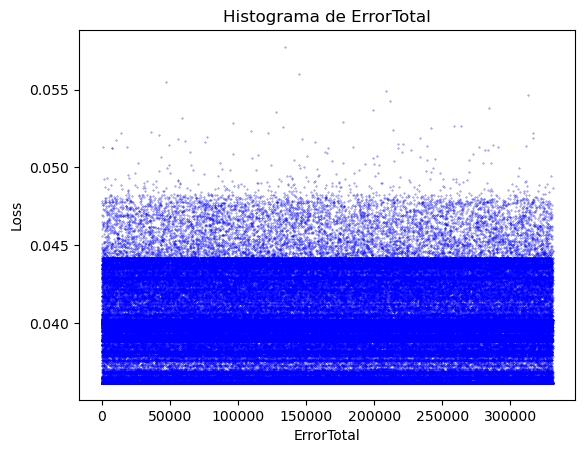

In [52]:
plt.scatter(range(len(df2['ErrorTotal'])), df2['ErrorTotal'], color='blue', alpha=0.7, s=0.1)
# Personalizar el gráfico
plt.xlabel('ErrorTotal')
plt.ylabel('Loss')
plt.title('Histograma de ErrorTotal')

# Mostrar el histograma
plt.show()